### Работа с данными 
+ В **июле** провели специальную акцию, направленную на улучшение ретеншена. 
+ **Новым** юзерам слали письмо с купоном. 

#### Сработала ли акция?

In [1]:
# import
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tckr

In [2]:
# данных всего на 3Мб, легко забираем в оперативку
trans_data = pd.read_csv('analyst_test_transactions_db.csv')

In [3]:
# сделаем текст датами
trans_data.reg_date = pd.to_datetime(trans_data.reg_date)
trans_data.transaction_date = pd.to_datetime(trans_data.transaction_date)

In [4]:
# оценим временной горизонт
print('диапазон дат регистрации',
      date.strftime(min(trans_data.reg_date), '%Y-%m-%d'),
      '..', 
      date.strftime(max(trans_data.reg_date), '%Y-%m-%d'),
      )
print('диапазон дат транзакций ',
      date.strftime(min(trans_data.transaction_date), '%Y-%m-%d'),
      '..', 
      date.strftime(max(trans_data.transaction_date), '%Y-%m-%d'),
      )

диапазон дат регистрации 1900-01-01 .. 2015-11-20
диапазон дат транзакций  2015-01-01 .. 2015-11-20


### Уточним задачу
+ "новыми" будем считать всех пользователей, которые зарегистрировались в июле 2015
+ retention rate будем смотреть по месячным когортам, на основании данных по 10 полным месяцам 2015

In [5]:
# иллюстрация данных
trans_data.sample(5)

,user_id,order_id,reg_date,transaction_date,revenue
59,53764,144402.0,2014-11-10,2015-05-05,1691
65020,67936,157688.0,2015-04-23,2015-04-23,1057
41882,66481,102717.0,2015-02-22,2015-06-17,1373
72563,56909,32961.0,2012-07-05,2015-10-01,1084
51447,23474,128135.0,2013-09-03,2015-01-18,1006


In [6]:
# приcваиваем номер кагорты = номер месяца
trans_data['cohort_no'] = trans_data.reg_date.dt.month

# добавим год для наглядности - будем рассматривать пользователей только 2015
# и без транзакций в ноябре т.к. данные за ноябрь неполные
trans_data['reg_year'] = trans_data.reg_date.dt.year
trans_data['trans_month'] = trans_data.transaction_date.dt.month
trans_data = trans_data.query('reg_year==2015 & trans_month<11')

# по каждой транзакции добавляем разницу с месяцем регистрации
trans_data['cohort_lifetime'] = trans_data.transaction_date.dt.month - trans_data.reg_date.dt.month

In [7]:
# теперь сгруппируем по когортам, рассчитывая кол-во уникальных пользователей в них по "месяцам жизни"
# т.о. считаем уников с транзакциями
cohorts = trans_data\
        .groupby(['cohort_no','cohort_lifetime'])\
        .agg(total_user_id = ('user_id','nunique')).reset_index()

# для упрощения расчёта, "размножим" на весь фрейм данные по первому месяцу
# для первого месяца, количество уников посчитаем по регистрациям, не по транзакциям
zero_cohorts_count = trans_data.groupby(['cohort_no']).agg(total_user_id = ('user_id','nunique')).reset_index()
zero_cohorts_count.columns = ['cohort_no', 'total_user_id_0']
cohorts = cohorts.merge(zero_cohorts_count, on='cohort_no')

# ура, добрались до retention rate: отношение уников за период к количеству зарегестрировавшихся в первый месяц когорты
cohorts['retention'] = cohorts['total_user_id']/cohorts['total_user_id_0']

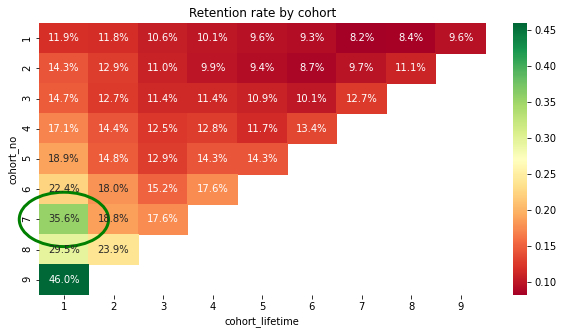

In [8]:
# отобразим метрику на hitmap
cohorts_pivot = cohorts\
        .pivot_table(
            index=cohorts['cohort_no'],
            columns='cohort_lifetime',
            values='retention',
            aggfunc='sum'
        )

plt.figure(figsize=(10, 5))
plt.title('Retention rate by cohort')
ax = sns.heatmap(
    cohorts_pivot.iloc[:-1,1:], 
    annot=True, fmt='.1%', cmap='RdYlGn'
)

ax.add_artist(plt.Circle((0.5, 6.5), 0.9, color='green', fill=False, clip_on=False, linewidth=3));

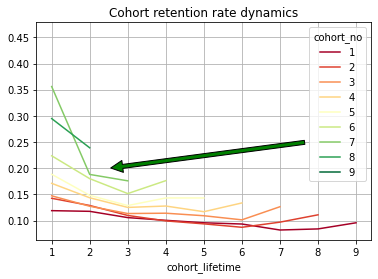

In [9]:
ax = cohorts_pivot.T.iloc[1:,:-1].plot(cmap='RdYlGn', grid=True, title='Cohort retention rate dynamics')
ax.annotate('',xy=(2.5, 0.2),
            xytext=(7.7, 0.25),
            arrowprops=dict(facecolor='green', shrink=0.01),
            horizontalalignment='right', verticalalignment='top');

### Очевидно, что акция принесла позитивный результат
+ динамика по месяцам лучше, чем по большинству когорт

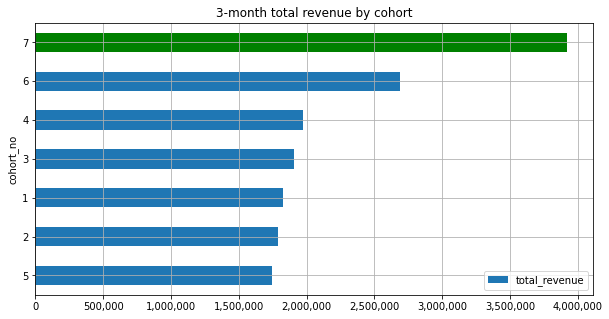

In [10]:
# сравним суммарную выручку по 1-7 кагортам за 3 месяца
ax = trans_data.query('cohort_no<8 & cohort_lifetime<4')\
    .groupby('cohort_no').agg(total_revenue=('revenue', 'sum'))\
    .sort_values(by='total_revenue')\
    .plot.barh(title='3-month total revenue by cohort', figsize=(10,5), grid=True)
ax.xaxis.set_major_formatter(tckr.StrMethodFormatter('{x:,.0f}'))
ax.patches[6].set_facecolor('green')

# Окончательный вывод: aкция сработала 
+ RR улучшился, по всем доступным периодам после акции
+ также зафиксирована рекордная сумма транзакций по первым 3 месяцам пользования сервисом - позитивная динамика LTV